# Regresión con data de viviendas

In [13]:
import findspark

findspark.add_jars('/app/postgresql-42.1.4.jar')
findspark.init()

In [14]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-postgres")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

In [15]:
spark.version

'2.4.5'

### Obtenemos el DF de psql

In [16]:
df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres/workshop") \
    .option("dbtable", "workshop.viviendas") \
    .option("user", "workshop") \
    .option("password", "w0rkzh0p") \
    .option("driver", "org.postgresql.Driver") \
    .load()

In [17]:
df.show(10)

+------+-----------------+---------------+------+----+-----+----+
|Precio|        Ubicacion|         Barrio|Metros|Dorm|Baños|Años|
+------+-----------------+---------------+------+----+-----+----+
|580000|         Belgrano|Capital Federal| 160.0|   4|    4|  38|
|550000|         Belgrano|Capital Federal| 160.0|   4|    4|  38|
|265000|     Villa Crespo|Capital Federal|  80.0|   2|    2|  45|
|200000|          Almagro|Capital Federal| 101.0|   3|    2|  40|
|195000|Parque Centenario|Capital Federal|  68.0|   2|    1|  35|
|270000|          Almagro|Capital Federal|  94.0|   3|    3|  40|
|213000|          Palermo|Capital Federal|  75.0|   3|    1|  40|
|139000|          Almagro|Capital Federal|  44.0|   1|    1|   5|
|104000|     Palermo Soho|        Palermo|  46.0|   1|    1|   0|
|138000|     Villa Crespo|Capital Federal|  46.0|   1|    1|   0|
+------+-----------------+---------------+------+----+-----+----+
only showing top 10 rows



In [18]:
df.count()

16040

### Casteamos los datos

In [19]:
from pyspark.sql.types import DoubleType, IntegerType

In [20]:
# Casteo de datos
df.printSchema()

root
 |-- Precio: long (nullable = true)
 |-- Ubicacion: string (nullable = true)
 |-- Barrio: string (nullable = true)
 |-- Metros: double (nullable = true)
 |-- Dorm: long (nullable = true)
 |-- Baños: long (nullable = true)
 |-- Años: long (nullable = true)



In [21]:
def cast_cols(df, cols, new_type):
  for col in cols: 
     df = df.withColumn(col, df[col].cast(new_type()))
  return df

In [22]:
integer_cols = ['Años', 'Baños', 'Dorm']
float_cols = ['Precio', 'Metros']

In [23]:
df = cast_cols(df, integer_cols, IntegerType)
df = cast_cols(df, float_cols, DoubleType)

In [24]:
df.printSchema()

root
 |-- Precio: double (nullable = true)
 |-- Ubicacion: string (nullable = true)
 |-- Barrio: string (nullable = true)
 |-- Metros: double (nullable = true)
 |-- Dorm: integer (nullable = true)
 |-- Baños: integer (nullable = true)
 |-- Años: integer (nullable = true)



### Limpiamos DF

In [25]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s-%(name)s-%(levelname)s: %(message)s',
    handlers=[logging.FileHandler('/dataset/titanic_spark.log'), logging.StreamHandler()],
)
logger = logging.getLogger(__name__)

In [26]:
#Error Numbers are coded as 999
df_replaced=df.na.replace(999, None)

#### Drop Nulls

In [27]:
import numpy as np
import pyspark.sql.functions as f

In [28]:
@f.udf('double')
def np_log(x):
    if x is None:
        return 0
    return float(np.log(x + 1)) 

In [29]:
def _drop_nulls(df, max_null_prop=0.5):
    logger.info(
        f"Dropping columns with null ratio greater than {max_null_prop * 100}%..."
    )
    df_nulls = df.select([f.sum(f.col(c).isNull().cast('integer') / df.count()).alias(c) 
                          for c in df.columns])
    logger.info(f"Null proportions:\n {df_nulls.show()}")
    null_cols = [c for c in df_nulls.columns if df_nulls.select(c).first()[0] > max_null_prop 
                 and c not in PROTECTED_COLS]
    logger.info(f"Dropping the following {len(null_cols)} columns:\n {null_cols}")
    df = df.drop(*null_cols)
    return df

In [30]:
PROTECTED_COLS = ['Precio', 'train']
df = _drop_nulls(df_replaced)

2021-11-15 12:36:39,690-__main__-INFO: Dropping columns with null ratio greater than 50.0%...
2021-11-15 12:36:42,937-__main__-INFO: Null proportions:
 None


+-------------------+---------+------+-------------------+--------------------+--------------------+-------------------+
|             Precio|Ubicacion|Barrio|             Metros|                Dorm|               Baños|               Años|
+-------------------+---------+------+-------------------+--------------------+--------------------+-------------------+
|0.01882793017456365|      0.0|   0.0|0.04183291770573582|0.001745635910224...|0.022506234413965164|0.20872817955110684|
+-------------------+---------+------+-------------------+--------------------+--------------------+-------------------+



2021-11-15 12:36:44,978-__main__-INFO: Dropping the following 0 columns:
 []


#### Drop Low Variance

In [31]:
def _drop_std(df, min_std_dev=1.5e-2):
    num_cols = [c for c,dtype in df.dtypes if dtype.startswith(('int', 'double'))]
    df_std = df.select([f.stddev(f.col(c)).alias(c) for c in num_cols])
    low_variance_cols = [c for c in df_std.columns if df_std.select(c).first()[0] < min_std_dev 
                         and c not in PROTECTED_COLS]
    logger.info(
        f'Dropping the following {len(low_variance_cols)} columns '
        f'due to low variance:\n {low_variance_cols}'
    )
    df.drop(*low_variance_cols)
    return df


In [32]:
df = _drop_std(df)

2021-11-15 12:36:46,475-__main__-INFO: Dropping the following 0 columns due to low variance:
 []


In [33]:
#El campo Barrio es impreciso y tiene muy poca varianza por lo cual no sirve para el modelo
df.select('Barrio').groupby('Barrio').count().orderBy(f.desc('count')).show(100)

[Stage 46:>                                                         (0 + 1) / 1]

+---------------+-----+
|         Barrio|count|
+---------------+-----+
|Capital Federal|11618|
|   Barrio Norte| 1120|
|        Palermo| 1066|
|       Belgrano|  888|
|         Centro|  861|
|  Villa Urquiza|  157|
|      Caballito|  137|
|       Floresta|   95|
|         Flores|   31|
|          Nuñez|   31|
|        Almagro|   28|
|      Mataderos|    5|
|   Villa Devoto|    2|
|      Argentina|    1|
+---------------+-----+



In [34]:
def _drop_unusable_cols(df, cols=[]):
    logger.info(
        f"Dropping the following {len(cols)} unusable columns:\n"
        f"{cols}"
    )
    df = df.drop(*cols)
    logger.info(
        f"Remaining {len(df.columns)} columns:\n {sorted(df.columns)}"
    )
    return df

In [35]:
df = _drop_unusable_cols(df, cols=['Barrio'])

2021-11-15 12:36:47,727-__main__-INFO: Dropping the following 1 unusable columns:
['Barrio']
2021-11-15 12:36:47,735-__main__-INFO: Remaining 6 columns:
 ['Años', 'Baños', 'Dorm', 'Metros', 'Precio', 'Ubicacion']


#### Drop Rows con Target Null

In [36]:
#Count Null Values in Target Column Precio
NullRows= df.toPandas()['Precio'].isna().sum()
print("From ", df.count(), "rows , ", NullRows," are null values")

From  16040 rows ,  302  are null values


In [37]:
#Drop
logger.info(f'Dropping the following {NullRows} rows due to target column Null')
df = df.filter(df.Precio. isNotNull())

2021-11-15 12:36:49,787-__main__-INFO: Dropping the following 302 rows due to target column Null


In [38]:
#Count Null Values in Target Column Precio

print("From ", df.count(), "rows , ", df.toPandas()['Precio'].isna().sum()," are null values")

From  15738 rows ,  0  are null values


#### Replace Null Values

In [39]:
def _get_typed_cols(df, col_type='cat'):
    assert col_type in ('cat', 'num')
    dtypes = ('int', 'double') if col_type == 'num' else ('string')
    typed_cols = [c for c,dtype in df.dtypes if dtype.startswith(dtypes) 
                  and c not in PROTECTED_COLS]
    return typed_cols

In [40]:
num_cols = _get_typed_cols(df, col_type='num')
cat_cols = _get_typed_cols(df, col_type='cat')
num_cols, cat_cols

(['Metros', 'Dorm', 'Baños', 'Años'], ['Ubicacion'])

In [41]:
#Values to replace Nulls for each column--> Median
df.toPandas().median()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Precio    253839.5
Metros        79.0
Dorm           2.0
Baños          2.0
Años          15.0
dtype: float64

In [42]:
def _fill_nulls(df):
    for t in ['num', 'cat']:
        cols = _get_typed_cols(df, col_type=t)
        for c in cols:
            if t == 'num':
                median_val = df.approxQuantile(c, [0.5], 0)[0]
                df = df.fillna(median_val, subset=[c])
            else:
                val_counts = df.filter(f.col(c).isNotNull()).select(c).groupBy(c).count().orderBy(f.desc('count'))
                common_val = val_counts.select(c).first()[0]
                df = df.fillna(common_val, subset=[c])
    return df

In [43]:
# Before Replacing Nulls
df.toPandas().isnull().mean()

Precio       0.000000
Ubicacion    0.000000
Metros       0.040857
Dorm         0.001779
Baños        0.022303
Años         0.202758
dtype: float64

In [44]:
df = _fill_nulls(df)

In [45]:
# After Replacing Nulls
df.toPandas().isnull().mean()

Precio       0.0
Ubicacion    0.0
Metros       0.0
Dorm         0.0
Baños        0.0
Años         0.0
dtype: float64

### Enriquecimiento DF

#### Agregamos Comuna

In [46]:
# A partir del barrio vamos a cargarle la comuna


#File Ciudad de Buenos Aires = https://data.buenosaires.gob.ar/dataset/barrios
dfBarrios = spark.read.csv('/dataset/barrios_comunas_p_Ciencia_de_Datos_y_PP.csv', header=True)
dfBarrios.show(5)

+---------+------+
|   BARRIO|COMUNA|
+---------+------+
|AGRONOMIA|    15|
|  ALMAGRO|     5|
|BALVANERA|     3|
| BARRACAS|     4|
| BELGRANO|    13|
+---------+------+
only showing top 5 rows



In [47]:
from itertools import chain
from pyspark.sql.functions import upper,col,regexp_replace

#Normalizamos algunos aspectos del campo Ubicacion
columnName="Ubicacion"
df=df.withColumn(columnName, upper(col(columnName)));
df=df.withColumn('Ubicacion', regexp_replace('Ubicacion', 'Í', 'I'))
df=df.withColumn('Ubicacion', regexp_replace('Ubicacion', 'Á', 'A'))

#Join para Obtener Comuna
df=df.join( dfBarrios, df.Ubicacion.contains(dfBarrios.BARRIO), "left")


In [48]:
#Barrios No encontrados
df.filter(df.COMUNA.isNull()).groupby('Ubicacion').count().orderBy(f.desc('count')).show(50)
df=df.drop(col("Ubicacion"))

+----------------+-----+
|       Ubicacion|count|
+----------------+-----+
|   CID CAMPEADOR|   15|
|     BARRIO NAÓN|    5|
|         POMPEYA|    5|
|           RIVER|    4|
|      TRIBUNALES|    3|
|   PRIMERA JUNTA|    3|
|   PARQUE LEZICA|    2|
|BARRIO SAN PEDRO|    2|
| CAPITAL FEDERAL|    1|
+----------------+-----+



In [49]:
#Drop Rows without Comuna
NullRows= df.toPandas()['COMUNA'].isna().sum()
logger.info(f'Dropping the following {NullRows} rows due to Enrichment column Null')
df = df.filter(df.COMUNA. isNotNull())

2021-11-15 12:37:00,477-__main__-INFO: Dropping the following 40 rows due to Enrichment column Null


In [50]:
df.count()
df.show(7)

+--------+------+----+-----+----+-----------------+------+
|  Precio|Metros|Dorm|Baños|Años|           BARRIO|COMUNA|
+--------+------+----+-----+----+-----------------+------+
|580000.0| 160.0|   4|    4|  38|         BELGRANO|    13|
|550000.0| 160.0|   4|    4|  38|         BELGRANO|    13|
|265000.0|  80.0|   2|    2|  45|     VILLA CRESPO|    15|
|200000.0| 101.0|   3|    2|  40|          ALMAGRO|     5|
|195000.0|  68.0|   2|    1|  35|PARQUE CENTENARIO|     5|
|270000.0|  94.0|   3|    3|  40|          ALMAGRO|     5|
|213000.0|  75.0|   3|    1|  40|          PALERMO|    14|
+--------+------+----+-----+----+-----------------+------+
only showing top 7 rows



#### Agregamos Precio/M2 para Validacion

In [51]:
df = df.withColumn('PrecioM2', col('Precio') / col('Metros'))

### Validacion de datos

#### Precio

In [52]:
#There seem to be some outliers in Column Precio due to Precios in $ mixed with Precios in USD
df.orderBy(f.desc('Precio')).show(10)

+-----------+------+----+-----+----+---------+------+------------------+
|     Precio|Metros|Dorm|Baños|Años|   BARRIO|COMUNA|          PrecioM2|
+-----------+------+----+-----+----+---------+------+------------------+
|5.5408914E7| 124.0|   3|    3|   0|  PALERMO|    14| 446846.0806451613|
| 5.337332E7| 100.0|   3|    2|   0|    NUÑEZ|    13|          533733.2|
| 4.867772E7|  80.0|   3|    2|   0|    NUÑEZ|    13|          608471.5|
| 4.182621E7|  83.0|   2|    2|   0|    NUÑEZ|    13| 503930.2409638554|
|3.4843718E7|  78.0|   2|    2|   0|    NUÑEZ|    13| 446714.3333333333|
|2.5878768E7|  46.0|   1|    1|   0|    NUÑEZ|    13| 562581.9130434783|
|  7900000.0| 650.0|   4|    5|   3| BELGRANO|    13|12153.846153846154|
|  6899000.0|  79.0|   2|    2|   0|CABALLITO|     6| 87329.11392405063|
|  5800000.0|  79.0|   0|    2|  15| RECOLETA|     2| 73417.72151898734|
|  5500000.0| 500.0|   5|    6|   0| BELGRANO|    13|           11000.0|
+-----------+------+----+-----+----+---------+-----

In [53]:
DeletedRows= df.filter(df.Precio >= 10000000).count()
logger.info(f'Dropping the following {DeletedRows} rows due to Price Outlier greater than 10.000.000 USD')
df = df.filter(df.Precio < 10000000)
df.count()

2021-11-15 12:37:03,315-__main__-INFO: Dropping the following 6 rows due to Price Outlier greater than 10.000.000 USD


15784

#### Metros

In [54]:
df.orderBy(f.asc('Metros')).show(25)

+---------+------+----+-----+----+----------------+------+------------------+
|   Precio|Metros|Dorm|Baños|Años|          BARRIO|COMUNA|          PrecioM2|
+---------+------+----+-----+----+----------------+------+------------------+
| 628000.0|   1.0|   4|    5|  19|       URQUIZA R|    12|          628000.0|
|1950000.0|   1.0|   2|    3|  15|    BARRIO NORTE|     2|         1950000.0|
| 229000.0|   1.0|   2|    1|  15|        BELGRANO|    13|          229000.0|
| 160000.0|   1.0|   1|    1|  25|          FLORES|     7|          160000.0|
| 160000.0|   1.0|   1|    1|  25|        FLORESTA|    10|          160000.0|
| 229000.0|   1.0|   2|    1|  15|      COLEGIALES|    13|          229000.0|
| 850000.0|   1.0|   3|    3|  15|   PUERTO MADERO|     1|          850000.0|
| 110000.0|   1.0|   2|    1|  21|VILLA DEL PARQUE|    11|          110000.0|
| 850000.0|   1.8|   2|    2|  15|   PUERTO MADERO|     1| 472222.2222222222|
|  46800.0|   2.6|   1|    1|   0|          ABASTO|     3|      

In [55]:
DeletedRows= df.filter(df.Metros < 10).count()
logger.info(f'Dropping the following {DeletedRows} rows due to Minimum Metros less than 10')
df = df.filter(df.Metros >= 10)
df.count()

2021-11-15 12:37:05,612-__main__-INFO: Dropping the following 14 rows due to Minimum Metros less than 10


15770

In [56]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


2021-11-15 12:37:07,467-matplotlib.font_manager-INFO: generated new fontManager


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


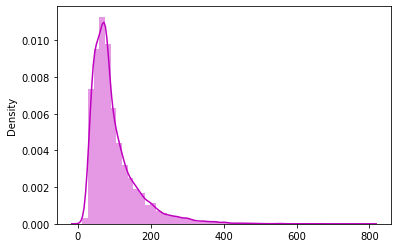

In [57]:
g = sns.distplot(df.select('Metros').toPandas(), color='m')

In [58]:
# We are not interested for this experiment in cases bigger than 400 Metros
DeletedRows= df.filter(df.Metros > 300).count()
logger.info(f'Dropping the following {DeletedRows} rows due to Maximum Metros greater than 300')
df = df.filter(df.Metros <= 300)
df.count()


2021-11-15 12:37:11,374-__main__-INFO: Dropping the following 288 rows due to Maximum Metros greater than 300


15482

#### Precio M2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


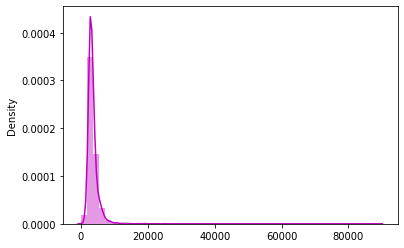

In [59]:
g = sns.distplot(df.select('PrecioM2').toPandas(), color='m')

In [60]:
df.orderBy(f.desc('PrecioM2')).show(25)

+---------+------+----+-----+----+-------------+------+------------------+
|   Precio|Metros|Dorm|Baños|Años|       BARRIO|COMUNA|          PrecioM2|
+---------+------+----+-----+----+-------------+------+------------------+
|5000345.0|  56.0|   3|    1|  50|  SAN NICOLAS|     1|         89291.875|
|6899000.0|  79.0|   2|    2|   0|    CABALLITO|     6| 87329.11392405063|
|5800000.0|  79.0|   0|    2|  15|     RECOLETA|     2| 73417.72151898734|
|2950000.0|  79.0|   3|    3|  16|PUERTO MADERO|     1| 37341.77215189873|
|2500000.0|  79.0|   5|    3|  40|     BELGRANO|    13|31645.569620253165|
|2490000.0|  79.0|   3|    4|   2|PUERTO MADERO|     1| 31518.98734177215|
|2400000.0|  79.0|   4|    4|  20|      PALERMO|    14| 30379.74683544304|
|2399000.0|  79.0|   3|    4|  15|PUERTO MADERO|     1| 30367.08860759494|
|2300000.0|  79.0|   3|    6|  25|      PALERMO|    14| 29113.92405063291|
|2300000.0|  79.0|   4|    4|   9|PUERTO MADERO|     1| 29113.92405063291|
| 460000.0|15.973|   2|  

In [61]:
DeletedRows= df.filter(df.PrecioM2 > 8500).count()
logger.info(f'Dropping the following {DeletedRows} rows due to Precio M2  greater than USD 8.500')
df = df.filter(df.PrecioM2 <= 8500)
df.count()

2021-11-15 12:37:15,140-__main__-INFO: Dropping the following 199 rows due to Precio M2  greater than USD 8.500


15283

#### Años

In [62]:
df.groupby('Años').count().orderBy(f.desc('Años')).show(25)

+-----+-----+
| Años|count|
+-----+-----+
|40000|    3|
|30000|    1|
| 2020|    1|
| 2019|    1|
| 2017|    1|
| 2015|    2|
| 2013|    3|
| 2012|    1|
| 2010|    3|
| 2007|    1|
| 2006|    1|
| 1991|    1|
| 1988|    2|
| 1985|    1|
| 1983|    1|
| 1981|    2|
| 1980|    2|
| 1978|    1|
| 1976|    3|
| 1961|    1|
| 1960|    3|
|  103|    1|
|  100|    6|
|   97|    1|
|   91|    2|
+-----+-----+
only showing top 25 rows



In [63]:
from datetime import date
  
# creating the date object of today's date
currentYear = date.today().year

DeletedRows= df.filter(df.Años > currentYear).count()
logger.info(f'Dropping the following {DeletedRows} rows due to Invalid Info in Años')
df = df.filter(df.Años <= currentYear)
df.count()

2021-11-15 12:37:17,720-__main__-INFO: Dropping the following 4 rows due to Invalid Info in Años


15279

In [64]:
# Corrijo los campos del año que son calculables
from pyspark.sql.functions import when,mean
CorrectedRows=df.filter(df.Años > 1700).count()
logger.info(f'Correcting the following {CorrectedRows} rows due to Year of construction in Años')
df=df.withColumn("Años", when(df["Años"] > 1700 , currentYear-df["Años"]).otherwise(df["Años"]))
#df = df.withColumn('title', when(df['title'] == 'Miss', 'Mrs').otherwise(df['title']))

2021-11-15 12:37:19,100-__main__-INFO: Correcting the following 31 rows due to Year of construction in Años


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


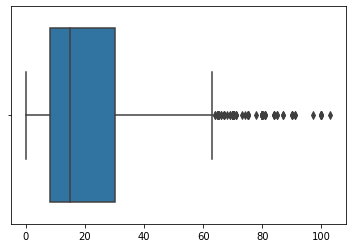

In [65]:
#Box Plot Años
g = sns.boxplot(df.select("Años").rdd.flatMap(lambda x: x).collect())

#### Entendemos el DF

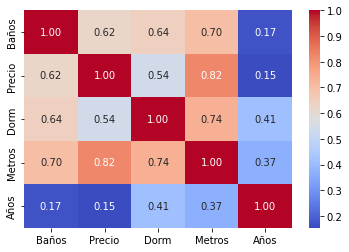

In [66]:
g = sns.heatmap(df.select('Baños', 'Precio', 'Dorm', 'Metros', 'Años').toPandas().corr(),
                annot=True, fmt = ".2f", cmap = "coolwarm")

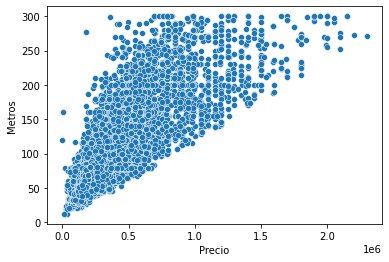

In [67]:
ax = sns.scatterplot(x="Precio", y="Metros", data=df.toPandas())

In [68]:
dfP=df.toPandas()


print (" Valores Totales: " , dfP.Precio.count() , "\n Valores Repetidos: ", sum(dfP.duplicated()),"\n Valores Unicos: ", dfP.Precio.count() - sum(dfP.duplicated()))

 Valores Totales:  15279 
 Valores Repetidos:  755 
 Valores Unicos:  14524


In [69]:
df.groupby('BARRIO','COMUNA').agg(mean("PrecioM2")).orderBy(f.desc('avg(PrecioM2)')).show(10)

+----------------+------+------------------+
|          BARRIO|COMUNA|     avg(PrecioM2)|
+----------------+------+------------------+
|   PUERTO MADERO|     1|5745.0425864044055|
|     LAS CAÑITAS|    14| 4054.496877721039|
|         PALERMO|    14|3987.2322283170106|
|PARQUE LAS HERAS|    14|3928.1639031346995|
|        BOTANICO|    14| 3779.942980382309|
|           NUÑEZ|    13|  3677.78057573725|
|        BELGRANO|    13| 3663.374957096726|
|        RECOLETA|     2| 3493.507231068262|
|       URQUIZA R|    12| 3481.746237118997|
|    BARRIO NORTE|     2| 3438.292519923174|
+----------------+------+------------------+
only showing top 10 rows



In [70]:
#Drop PrecioM2 
df=df.drop(col("PrecioM2"))

### Split Train Test

In [71]:
from pyspark.sql.functions import rand, when,mean
df = df.withColumn('train', when(rand(seed=1234) >= 0.25, True).otherwise(False))

In [72]:
df.select('train').groupby('train').count().show()

+-----+-----+
|train|count|
+-----+-----+
| true|11419|
|false| 3860|
+-----+-----+



### Preprocessing Pipeline

In [73]:
num_cols = _get_typed_cols(df, col_type='num')
cat_cols = _get_typed_cols(df, col_type='cat')
df.columns, cat_cols, num_cols

(['Precio', 'Metros', 'Dorm', 'Baños', 'Años', 'BARRIO', 'COMUNA', 'train'],
 ['BARRIO', 'COMUNA'],
 ['Metros', 'Dorm', 'Baños', 'Años'])

In [74]:
from pyspark.ml.feature import StringIndexer

def _encode_categorical(df):
    cat_cols = _get_typed_cols(df, col_type='cat')
    logger.info(f"Categorical columns:\n {cat_cols}")
    encoded_cols = []
    for cat in cat_cols:
        cat_suff = f'{cat}_num'
        encoded_cols.append(cat_suff)
        if cat_suff not in df.columns:
            indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(df)
            df = indexer.transform(df)
    return df, encoded_cols

In [75]:
df, encoded_cols = _encode_categorical(df)
df.show(5)

2021-11-15 12:37:28,518-__main__-INFO: Categorical columns:
 ['BARRIO', 'COMUNA']


+--------+------+----+-----+----+-----------------+------+-----+----------+----------+
|  Precio|Metros|Dorm|Baños|Años|           BARRIO|COMUNA|train|BARRIO_num|COMUNA_num|
+--------+------+----+-----+----+-----------------+------+-----+----------+----------+
|580000.0| 160.0|   4|    4|  38|         BELGRANO|    13| true|       0.0|       0.0|
|550000.0| 160.0|   4|    4|  38|         BELGRANO|    13| true|       0.0|       0.0|
|265000.0|  80.0|   2|    2|  45|     VILLA CRESPO|    15| true|      11.0|       9.0|
|200000.0| 101.0|   3|    2|  40|          ALMAGRO|     5| true|       9.0|       8.0|
|195000.0|  68.0|   2|    1|  35|PARQUE CENTENARIO|     5| true|      33.0|       8.0|
+--------+------+----+-----+----+-----------------+------+-----+----------+----------+
only showing top 5 rows



In [76]:
feature_cols = num_cols + encoded_cols
feature_cols

['Metros', 'Dorm', 'Baños', 'Años', 'BARRIO_num', 'COMUNA_num']

In [77]:
from pyspark.ml.feature import OneHotEncoderEstimator

ohe_cols = [f'{c}_vec' for c in encoded_cols]
encoder = OneHotEncoderEstimator(inputCols=encoded_cols, outputCols=ohe_cols)
ohem = encoder.fit(df)
df = ohem.transform(df)
df.show(5)
feature_cols = num_cols + ohe_cols

+--------+------+----+-----+----+-----------------+------+-----+----------+----------+---------------+--------------+
|  Precio|Metros|Dorm|Baños|Años|           BARRIO|COMUNA|train|BARRIO_num|COMUNA_num| BARRIO_num_vec|COMUNA_num_vec|
+--------+------+----+-----+----+-----------------+------+-----+----------+----------+---------------+--------------+
|580000.0| 160.0|   4|    4|  38|         BELGRANO|    13| true|       0.0|       0.0| (57,[0],[1.0])|(14,[0],[1.0])|
|550000.0| 160.0|   4|    4|  38|         BELGRANO|    13| true|       0.0|       0.0| (57,[0],[1.0])|(14,[0],[1.0])|
|265000.0|  80.0|   2|    2|  45|     VILLA CRESPO|    15| true|      11.0|       9.0|(57,[11],[1.0])|(14,[9],[1.0])|
|200000.0| 101.0|   3|    2|  40|          ALMAGRO|     5| true|       9.0|       8.0| (57,[9],[1.0])|(14,[8],[1.0])|
|195000.0|  68.0|   2|    1|  35|PARQUE CENTENARIO|     5| true|      33.0|       8.0|(57,[33],[1.0])|(14,[8],[1.0])|
+--------+------+----+-----+----+-----------------+-----

In [78]:
feature_cols

['Metros', 'Dorm', 'Baños', 'Años', 'BARRIO_num_vec', 'COMUNA_num_vec']

In [79]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)
df.select('features').show(1)

+--------------------+
|            features|
+--------------------+
|(75,[0,1,2,3,4,61...|
+--------------------+
only showing top 1 row



In [80]:
train_data = df.filter(f.col('train') == True).select('Precio', 'features')
test_data = df.filter(f.col('train') == False).select('Precio', 'features')

## Testing modelos

### Linear Regression

In [81]:
from pyspark.ml.regression import LinearRegression


lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8,labelCol='Precio', featuresCol='features')

# Fit the model
lrModel = lr.fit(train_data)

[Stage 152:>                                                        (0 + 1) / 1]21/11/15 12:37:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/11/15 12:37:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [82]:
pred_df = lrModel.transform(test_data)

In [83]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='Precio')
print ("R2:   ",evaluator.evaluate(pred_df, {evaluator.metricName: "r2"}))
print ("RMSE: ",evaluator.evaluate(pred_df, {evaluator.metricName: "rmse"}))
print ("MAE:  ",evaluator.evaluate(pred_df, {evaluator.metricName: "mae"}))


R2:    0.7629572529287415
RMSE:  120690.09615839328
MAE:   75123.85532144249


### Decision Trees

In [84]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(labelCol='Precio', featuresCol='features',maxDepth=8, maxBins=32)
dtModel = dt.fit(train_data)

In [85]:
pred_df = dtModel.transform(test_data)

In [86]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='Precio')
print ("R2:   ",evaluator.evaluate(pred_df, {evaluator.metricName: "r2"}))
print ("RMSE: ",evaluator.evaluate(pred_df, {evaluator.metricName: "rmse"}))
print ("MAE:  ",evaluator.evaluate(pred_df, {evaluator.metricName: "mae"}))


R2:    0.766991723949067
RMSE:  119658.61476517876
MAE:   71226.03575342063


### RandomForest

In [87]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol='Precio', featuresCol='features',maxDepth=8)
rfModel = rf.fit(train_data)

In [88]:
pred_df = rfModel.transform(test_data)

In [89]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='Precio')
print ("R2:   ",evaluator.evaluate(pred_df, {evaluator.metricName: "r2"}))
print ("RMSE: ",evaluator.evaluate(pred_df, {evaluator.metricName: "rmse"}))
print ("MAE:  ",evaluator.evaluate(pred_df, {evaluator.metricName: "mae"}))


R2:    0.771787241162841
RMSE:  118420.87293041755
MAE:   70491.59781835259


### Gradient-boosted tree regression

In [90]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol='Precio', featuresCol='features',maxDepth=5)
gbtModel = gbt.fit(train_data)

In [91]:
pred_df

DataFrame[Precio: double, features: vector, prediction: double]

In [92]:
from pyspark.ml.evaluation import RegressionEvaluator

pred_df = gbtModel.transform(test_data)
evaluator = RegressionEvaluator(labelCol='Precio')
print ("R2:   ",evaluator.evaluate(pred_df, {evaluator.metricName: "r2"}))
print ("RMSE: ",evaluator.evaluate(pred_df, {evaluator.metricName: "rmse"}))
print ("MAE:  ",evaluator.evaluate(pred_df, {evaluator.metricName: "mae"}))


R2:    0.7946752708246505
RMSE:  112325.64649875398
MAE:   67532.2843106857


## GridSearch + Cross Validation on GBT

In [93]:
CrossValidator?

Object `CrossValidator` not found.


In [94]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
import pandas as pd


gbt =  GBTRegressor(labelCol='Precio', featuresCol='features')

paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [5,6,7])\
  .addGrid(gbt.maxBins, [10,32,50])\
  .addGrid(gbt.maxIter, [20,40,60,80])\
  .build()


pipeline = Pipeline(stages=[gbt])

evaluator = RegressionEvaluator()
evaluator.setLabelCol("Precio")
evaluator.setMetricName("r2")

# Declare the CrossValidator, which performs the model tuning.
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, estimatorParamMaps=paramGrid,numFolds=3)
cv.setCollectSubModels(False) # cv after fitting returns only one model


CrossValidator_23bd24cda1a1

In [95]:
cvModel = cv.fit(train_data)

In [96]:
model=cvModel
params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()]
     
summary=pd.DataFrame.from_dict([
  {model.getEvaluator().getMetricName(): metric, **ps} 
  for ps, metric in zip(params, model.avgMetrics)
])
summary=summary.sort_values("r2", ascending=False)
summary

,r2,maxDepth,maxBins,maxIter
11,0.800542,5,50,80
10,0.799169,5,50,60
9,0.797853,5,50,40
22,0.793079,6,50,60
8,0.792940,5,50,20
21,0.792225,6,50,40
23,0.791614,6,50,80
20,0.788016,6,50,20
6,0.786142,5,32,60
7,0.785188,5,32,80


In [97]:
BestModelParams = summary.loc[summary['r2'] == summary['r2'].max()]
gbt =  GBTRegressor(labelCol='Precio', featuresCol='features',
                    maxDepth=BestModelParams.maxDepth.values[0],maxBins=BestModelParams.maxBins.values[0],maxIter=BestModelParams.maxIter.values[0])

gbtBestModel = gbt.fit(train_data)
pred_df = gbtBestModel.transform(test_data)
print ("R2:   ",evaluator.evaluate(pred_df, {evaluator.metricName: "r2"}))
print ("RMSE: ",evaluator.evaluate(pred_df, {evaluator.metricName: "rmse"}))
print ("MAE:  ",evaluator.evaluate(pred_df, {evaluator.metricName: "mae"}))

R2:    0.8027593491765941
RMSE:  110092.19000440772
MAE:   63487.48582350465


In [98]:
from itertools import chain
attrs = sorted(
    (attr['idx'], attr['name'])
    for attr in (
        chain(*pred_df.schema['features'].metadata['ml_attr']['attrs'].values())
    )
)
feat_import = [(name, gbtBestModel.featureImportances[idx]) for idx, name in attrs if gbtBestModel.featureImportances[idx]]
feat_import = pd.DataFrame(feat_import, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
feat_import.head(10)

,feature,importance
0,Metros,0.333525
3,Años,0.227811
1,Dorm,0.108248
2,Baños,0.081286
5,BARRIO_num_vec_PALERMO,0.026685
51,COMUNA_num_vec_14,0.020326
11,BARRIO_num_vec_PUERTO MADERO,0.018484
53,COMUNA_num_vec_2,0.013386
4,BARRIO_num_vec_BELGRANO,0.012855
7,BARRIO_num_vec_RECOLETA,0.010878


[Text(0, 0, 'Metros'),
 Text(1, 0, 'Años'),
 Text(2, 0, 'Dorm'),
 Text(3, 0, 'Baños'),
 Text(4, 0, 'BARRIO_num_vec_PALERMO'),
 Text(5, 0, 'COMUNA_num_vec_14'),
 Text(6, 0, 'BARRIO_num_vec_PUERTO MADERO'),
 Text(7, 0, 'COMUNA_num_vec_2'),
 Text(8, 0, 'BARRIO_num_vec_BELGRANO'),
 Text(9, 0, 'BARRIO_num_vec_RECOLETA')]

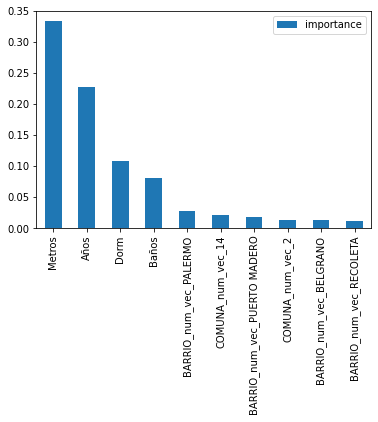

In [99]:
ax = feat_import[:10].plot(kind='bar')
ax.set_xticklabels(feat_import[:10]['feature'].tolist())

In [100]:
spark.stop()